<a href="https://colab.research.google.com/github/hamednasr/CIFAR-10-classification/blob/main/CIFAR_10_Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CIFAR 10 Autoencoder

In [80]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import numpy as np
import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

In [81]:
trans = T.Compose([T.ToTensor()])

In [82]:
# device= 'cpu'
device = torch.device('cuda:0' if torch.cuda.is_available else 'cpu')
device

device(type='cuda', index=0)

In [83]:
train = torchvision.datasets.CIFAR10(root = 'cifar10',download=True,transform=trans)
train

Files already downloaded and verified


Dataset CIFAR10
    Number of datapoints: 50000
    Root location: cifar10
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )

In [84]:
test = torchvision.datasets.CIFAR10(root = 'cifar10',train=False,download=True,transform=trans)
test

Files already downloaded and verified


Dataset CIFAR10
    Number of datapoints: 10000
    Root location: cifar10
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
           )

In [85]:
trans(test.data[11,:]).shape

torch.Size([3, 32, 32])

In [86]:
test.transform(test.data[11,:]).shape

torch.Size([3, 32, 32])

In [87]:
train.data.shape

(50000, 32, 32, 3)

In [88]:
test.data.shape

(10000, 32, 32, 3)

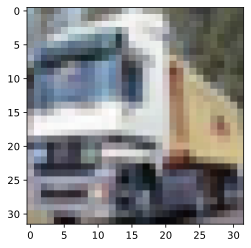

In [89]:
plt.imshow(train.data[1])

# data preparation for pytorch

In [90]:
train

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: cifar10
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )

In [91]:
batchsize=128
trainloader = DataLoader(train,batch_size=batchsize,shuffle=True,drop_last=True)

In [92]:
testloader = DataLoader(test,batch_size=10000)

## building model:

In [93]:
def CreateModel():
  
  class CNNmodel(nn.Module):
    def __init__(self):
      super().__init__()

      self.enc1 = nn.Conv2d(3,16,kernel_size=4,stride=2,padding=1) #first encoder layer
      # (32+2*1-4)/2+1=16 
      # self.batchnorm1 = nn.BatchNorm2d(16)
      
      self.enc2 = nn.Conv2d(16,32,kernel_size=4,stride=2,padding=1) #second encoder layer
      #(16+2*1-4)/2+1 = 8 
      # self.batchnorm2 = nn.BatchNorm2d(32)

      self.latent = nn.Conv2d(32,64,kernel_size=4,stride=2,padding=1) #latent layer
      # # #(8+2*1-4)/2+1 = 4
      # self.batchnorm3 = nn.BatchNorm2d(64)

      self.dec1 = nn.ConvTranspose2d(64,32,kernel_size=4,stride=2,padding=1) #first decoding layer

      self.dec2 = nn.ConvTranspose2d(32,16,kernel_size=4,stride=2,padding=1) #second decoding layer

      self.out = nn.ConvTranspose2d(16,3,kernel_size=4,stride=2,padding=1) #output layer

    
    def forward(self,x):

      x= F.leaky_relu(self.enc1(x))

      x= F.leaky_relu(self.enc2(x))
      
      x= F.leaky_relu(self.latent(x))

      x= F.leaky_relu(self.dec1(x))

      x= F.leaky_relu(self.dec2(x))

      x= F.leaky_relu(self.out(x))
      
      return x

  CNNAutoenc = CNNmodel()

  lossfun = nn.MSELoss()

  optimizer = torch.optim.Adam(params=CNNAutoenc.parameters(), lr = 0.001)

  return CNNAutoenc, lossfun, optimizer

## Sanity checking of the model:

In [94]:
X = torch.randn(5,3,32,32)
CNNAutoenc, lossfun, optimizer = CreateModel()
yhat = CNNAutoenc(X)
print(yhat.shape)


torch.Size([5, 3, 32, 32])


## Train the model:

In [95]:
epochs = 5

def TrainModel():

  CNNAutoenc, lossfun, optimizer = CreateModel()
  CNNAutoenc.to(device)


  trainloss = []
  testloss = []

  for i in range(epochs):
    
    CNNAutoenc.train()

    batchloss = []


    for X, y in trainloader:

      X = X.to(device)
      y = y.to(device)
      
      yhat = CNNAutoenc(X)

      loss = lossfun(yhat,X)
      batchloss.append(loss.item())

      optimizer.zero_grad()
      loss.backward()
      optimizer.step() 

    trainloss.append(np.mean(batchloss))


    CNNAutoenc.eval()
    X,y = next(iter(testloader))
    X = X.to(device)
    y = y.to(device)
    yhat = CNNAutoenc(X)
    testloss.append(lossfun(yhat,X).item())
    print(f'{i+1} of {epochs} epochs done.')

  return  CNNAutoenc, trainloss, testloss

In [96]:
CNNAutoenc, trainloss, testloss = TrainModel()

torch.Size([10000, 3, 32, 32])
torch.Size([10000, 3, 32, 32])
1 of 5 epochs done.
torch.Size([10000, 3, 32, 32])
torch.Size([10000, 3, 32, 32])
2 of 5 epochs done.
torch.Size([10000, 3, 32, 32])
torch.Size([10000, 3, 32, 32])
3 of 5 epochs done.
torch.Size([10000, 3, 32, 32])
torch.Size([10000, 3, 32, 32])
4 of 5 epochs done.
torch.Size([10000, 3, 32, 32])
torch.Size([10000, 3, 32, 32])
5 of 5 epochs done.


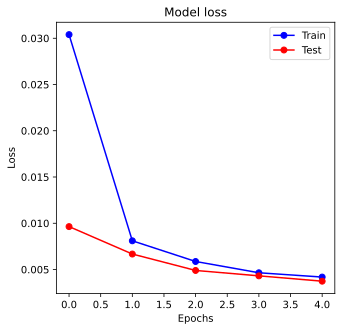

In [97]:
fig,ax = plt.subplots(1,1,figsize=(5,5))

ax.plot(trainloss,'bo-',label='Train')
ax.plot(testloss,'ro-',label='Test')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.set_title('Model loss')
ax.legend()

plt.show()

In [98]:
randomnums = np.random.choice(10000,10)

In [99]:
randomnums[0]

7457

In [100]:
next(iter(testloader))[0][randomnums,:].shape

torch.Size([10, 3, 32, 32])

In [101]:
test.data[randomnums,:].shape

(10, 32, 32, 3)

In [102]:
next(iter(testloader))[0][54,:].reshape(1,3,32,32).shape

torch.Size([1, 3, 32, 32])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

torch.Size([10, 32, 32, 3])
torch.Size([32, 32, 3])
torch.Size([32, 32, 3])
torch.Size([32, 32, 3])
torch.Size([32, 32, 3])
torch.Size([32, 32, 3])
torch.Size([32, 32, 3])
torch.Size([32, 32, 3])
torch.Size([32, 32, 3])
torch.Size([32, 32, 3])
torch.Size([32, 32, 3])


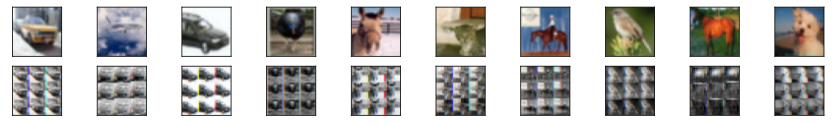

In [112]:
fig,ax = plt.subplots(2,10,figsize=(15,2))
randomnums = np.random.choice(5000,10)
X , y =  next(iter(testloader))
X = X.to(device)
CNNout = CNNAutoenc(X[randomnums,:]).detach().reshape(10,32,32,3).cpu()
print(CNNout.shape)
# CNNout.cpu()
for i in range(10):
  ax[0,i].imshow(test.data[randomnums[i],:])
  ax[0,i].set_xticks([])
  ax[0,i].set_yticks([])

for i in range(10):
  ax[1,i].imshow(CNNout[i,:])
  ax[1,i].set_xticks([])
  ax[1,i].set_yticks([])
  
  
# ax.plot(testloss,'ro-',label='Test')
# ax.set_xticks([])
# ax.set_ylabel('Loss')
# ax.set_title('Model loss')
# ax.legend()

plt.show()